**LLaMA**

In [1]:
TRAIN_PATH = '../data/'
# TEST_PATH = '/home/patrick/Documents/CSE_599/HW/2/testset/test.jsonl'
# VAL_PATH = '/home/patrick/Documents/CSE_599/HW/2/valset/val.jsonl'
MODEL_PATH = '/Users/anderson/Desktop/Project/LLaMA-From-Inference-to-Training/' #folder with generation.py, model.py, and tokenizer.py
TRAINED_SPM_PATH = './tokenizer.model' #downloaded from Ed post

**Init**

In [2]:
import torch

# Make sure INGESTED_SAMPLE_CNT % MAX_BSZ == 0; assymetric batches break something somewhere
# MAX_SEQ_LEN = 2048
MAX_SEQ_LEN = 512
INGESTED_SAMPLE_CNT = 8
MAX_BSZ = 16
MINI_MODEL = False
RESUME = True 
PRETRAINED_PATH = "./ckpts/test_ckpt/model.pth"
PARAMS_JSON_PATH = "./ckpts/test_ckpt/params.json"
DATA_PATH = "/Users/anderson/Downloads/11.jsonl.zst"

In [3]:
import sys
sys.path.append(MODEL_PATH)

# Copyright (c) Meta Platforms, Inc. and affiliates.
# This software may be used and distributed according to the terms of the GNU General Public License version 3.
from generation import LLaMA
from llama.model_train import ModelArgs, Transformer #ctrl+f and comment out cuda, all else same
#from model import ModelArgs, Transformer #use this one if you have NVIDIA GPU
from tokenizer import Tokenizer

**Data**

Data Model

In [4]:
from torch.nn.utils.rnn import pad_sequence
import numpy as np 
import json
from torch.utils.data import Dataset, DataLoader
import zstandard as zstd
import io

tokenizer = Tokenizer(TRAINED_SPM_PATH)

def read_line(line):
    line = line.strip()
    try:
        data = json.loads(line)
    except ValueError:
        return None
    return data['text']

def read_file(file_path, gbs=1.0, entries=10000):
    with open(file_path, 'rb') as file:
        decompressor = zstd.ZstdDecompressor()
        stream_reader = decompressor.stream_reader(file)
        stream = io.TextIOWrapper(stream_reader, encoding='utf-8')

        lines = []
        for line in stream:
            line = read_line(line)
            if line is not None:
                lines.append(line)
            if len(lines) == entries:
                break
    print(len(lines))
    return lines

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, random_mask=False, n_mask=1):
        self.texts = texts
        self.tokenizer = tokenizer
        self.random_mask = random_mask
        self.n_mask = n_mask

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded_text = self.tokenizer.encode(text, bos=False, eos=False)

        if not self.random_mask: 
            #Truncate the sequence to max_seq_len if it's too long
            if len(encoded_text) > MAX_SEQ_LEN - 1:  #We subtract 2 to account for the BOS and EOS tokens\
                                                    #small modification: -1 instead
                encoded_text = encoded_text[:MAX_SEQ_LEN - 1]           
            return {
                'input_ids': torch.tensor([self.tokenizer.bos_id] + encoded_text[:-1], dtype=torch.long),
                'target_ids': torch.tensor(encoded_text[1:] + [self.tokenizer.eos_id], dtype=torch.long)
            }
        else: 
            if len(encoded_text) > MAX_SEQ_LEN - 2:
                encoded_text = encoded_text[:MAX_SEQ_LEN - 2]
            return {
                'input_ids': torch.tensor([self.tokenizer.bos_id] + self.mask(encoded_text) + [self.tokenizer.eos_id], dtype=torch.long),
                'target_ids': torch.tensor([self.tokenizer.bos_id] + encoded_text + [self.tokenizer.eos_id], dtype=torch.long)
            }
    
    def mask(self, encoded_text): 
        idxs = np.random.choice(range(len(encoded_text)), size=self.n_mask)
        encoded_text[idxs] = self.tokenizer.pad_id
        return encoded_text


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    target_ids = [item['target_ids'] for item in batch]
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_id)
    target_ids = pad_sequence(target_ids, batch_first=True, padding_value=tokenizer.pad_id)
    return {
        'input_ids': input_ids,
        'target_ids': target_ids
    }

def train_test_split(lines, train_n, valid_n, test_n): 
    train_texts = []
    val_texts = []
    test_texts = []
    for idx, line in enumerate(lines): 
        if idx < train_n: 
            train_texts.append(line)
        elif idx < train_n + valid_n: 
            val_texts.append(line)
        elif idx < train_n + valid_n + test_n: 
            test_texts.append(line) 
        else: 
            break 
    return train_texts, val_texts, test_texts

# train_texts, val_texts, test_texts = train_test_split("../data/02_10000_entries.txt", 25000, 100, 2000)
train_texts, val_texts, test_texts = train_test_split(read_file(DATA_PATH, entries=30000), 27000, 100, 200)

train_dataset = TextDataset(train_texts, tokenizer)
val_dataset = TextDataset(val_texts, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=MAX_BSZ, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=MAX_BSZ, shuffle=True, collate_fn=collate_fn)

30000


Processed Data

In [5]:
def examine_data(data):
    '''debugging func'''
    print('Input type: {}'.format(type(data)))
    print('Length: {}'.format(len(data)))
    print('First element type: {}'.format(type(data[0])))
    if type(data[0])==dict:
        print('Keys: {}'.format(data[0].keys()))
    return

#debugging tools
def examine_tensor(tensor):
    '''debugging function'''
    print('TENSOR OVERVIEW\n'
          'Type: {}\n'
          'Data Type: {}\n'
          'Shape: {}\n'
          'Number of Dimensions: {}\n'
          'Device: {}\n'
          'Requires Grad: {}\n'
          'Gradient: {}\n'.format(tensor.type(), tensor.dtype, tensor.shape, tensor.ndim, tensor.device,\
                                  tensor.requires_grad, tensor.grad))
    return

def flag(msg='unspecified'):
    print('FLAG: {}'.format(msg))
    return

def loop_summary(titles:tuple, tensors:tuple):
    for i in range(len(titles)):
        flag(titles[i])
        examine_tensor(tensors[i])
    return

def examine_dataloader(dataloader):
    '''debugging function'''
    print('DATALOADER OVERVIEW\n'
          'Number of Batches: {}\n'
          'Batch Size: {}\n'.format(len(dataloader), dataloader.batch_size))

    # Examine the first batch in the dataloader
    first_batch = next(iter(dataloader))
    print('First batch overview:')
    print('Keys: ', first_batch.keys())
    
    for key in first_batch.keys():
        print('Shape of {} tensor: {}'.format(key, first_batch[key].shape))
    
    # Examine the dataset
    print('\nDataset overview:')
    print('Length of Dataset: ', len(dataloader.dataset))

    # Try getting an item from the dataset
    try:
        print('Example item: ', dataloader.dataset[0])
    except Exception as e:
        print('Could not retrieve item from dataset: ', str(e))
    return

examine_data(train_texts)
examine_dataloader(train_dataloader)

Input type: <class 'list'>
Length: 27000
First element type: <class 'str'>
DATALOADER OVERVIEW
Number of Batches: 1688
Batch Size: 16

First batch overview:
Keys:  dict_keys(['input_ids', 'target_ids'])
Shape of input_ids tensor: torch.Size([16, 511])
Shape of target_ids tensor: torch.Size([16, 511])

Dataset overview:
Length of Dataset:  27000
Example item:  {'input_ids': tensor([    1, 29301,   310,  6615,  1230, 18530,  4603,   472,   278,  4768,
         5996,  1889,  3233, 29889,    13,  4617,  1070, 10174,   526,   451,
        23968,  6471,   310,  4959, 29889, 25678, 29892,   297,  1556,  9200,
         2378,  3483,   952,   267, 29892,   896, 10331,   304,   367, 14914,
          408,  2317, 18785, 10340, 29889,  1763, 28453,  3578,   373,   920,
         5164,  5633,   310,   278,  1006, 29113,  4768,  5996, 10174,   526,
         6615,   630,   472,   278,  1301,  3395,  3233, 29892,   727,   338,
          263,   817,   304,  6559,   278,  1546, 29899,  5441,  4603,   284,


**Training**

Configure environment for CPU

In [6]:
import torch.distributed as dist
import fairscale.nn.model_parallel.initialize as fs_init

%env RANK=0
%env WORLD_SIZE=1
%env MASTER_ADDR=localhost
%env MASTER_PORT=0

torch.distributed.init_process_group(backend='gloo')
fs_init.initialize_model_parallel(1) #1 worker


env: RANK=0
env: WORLD_SIZE=1
env: MASTER_ADDR=localhost
env: MASTER_PORT=0
> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


Instantiate model

In [8]:
model_args = ModelArgs(
    dim=512,
    n_layers=8,
    n_heads=8,
    vocab_size=tokenizer.n_words,
    multiple_of=256,
    norm_eps=1e-5,
    max_batch_size=MAX_BSZ,
    max_seq_len=MAX_SEQ_LEN,
)

mini_args = ModelArgs(
    dim=256,
    n_layers=4,
    n_heads=4,
    vocab_size=tokenizer.n_words,
    multiple_of=256,
    norm_eps=1e-5,
    max_batch_size=MAX_BSZ, #only works for 32; no idea why
    max_seq_len=MAX_SEQ_LEN,
)

if RESUME: 
    print("Loading")
    checkpoint = torch.load(PRETRAINED_PATH, map_location="cpu")
    print(checkpoint.keys())
    with open(PARAMS_JSON_PATH, "r") as f:
        params = json.loads(f.read())
    model_args: ModelArgs = ModelArgs(
        max_seq_len=MAX_SEQ_LEN, max_batch_size=MAX_BSZ, **params
    )
    model_args.vocab_size = tokenizer.n_words
    model = Transformer(model_args)
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
elif MINI_MODEL: #global var (2nd cell)
    model = Transformer(mini_args)
else:
    model = Transformer(model_args)

optimizer = torch.optim.AdamW(model.parameters())
loss_func = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)  # ignores padding token for loss calculation

Loading
dict_keys(['model_state_dict', 'optimizer_state_dict'])


Training loop

In [9]:
def train():
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        print(f"Batch {i+1} / {len(train_dataloader)}")
        inputs = batch['input_ids'] #bsz x seq_len 
        targets = batch['target_ids'] #bsz x seq_len
        # examine_tensor(targets)

        outputs = model(inputs, start_pos=0) #bsz x sel_len x vocab_size

        flat_outputs = outputs.view(-1, outputs.size(-1)) #(bsz*seq_len) x vocab_size

        flat_targets = targets.view(-1) #(bsz*seq_len)

        loss = loss_func(flat_outputs, flat_targets) #might be incorrect to flatten, idk
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        val_loss = 0

        for val_batch in val_dataloader: 
            val_inputs = val_batch['input_ids']
            val_targets = val_batch['target_ids']

            outputs = model(val_inputs, start_pos=0)
            flat_outputs = outputs.view(-1, outputs.size(-1)) #(bsz*seq_len) x vocab_size
            flat_targets = val_targets.view(-1) #(bsz*seq_len)
            val_loss += loss_func(flat_outputs, flat_targets).item()
        
        val_loss = val_loss / len(val_dataloader)
        
        print(f"training loss = {loss.item()}")
        print(f"validation loss = {val_loss}")
        total_loss += loss.item()
        train_history.append(loss.item())
        val_history.append(val_loss)
    
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    return train_history, val_history 

train_history = [] 
val_history = []
train_history, val_history = train()

Batch 1 / 1688
training loss = 6.2764739990234375
validation loss = 6.283916745867048
Batch 2 / 1688
training loss = 6.152665615081787
validation loss = 6.3304460389273505
Batch 3 / 1688
training loss = 6.078392505645752
validation loss = 6.234792573111398
Batch 4 / 1688
training loss = 6.14769983291626
validation loss = 6.187223843165806
Batch 5 / 1688
training loss = 5.744284629821777
validation loss = 6.301237991877964
Batch 6 / 1688
training loss = 6.20932149887085
validation loss = 6.3174342427934915
Batch 7 / 1688
training loss = 6.487209796905518
validation loss = 6.304231779915946
Batch 8 / 1688
training loss = 6.39265775680542
validation loss = 6.313112395150321
Batch 9 / 1688
training loss = 6.085101127624512
validation loss = 6.282311235155378
Batch 10 / 1688
training loss = 6.101283550262451
validation loss = 6.257691451481411
Batch 11 / 1688
training loss = 6.437716007232666
validation loss = 6.304724420819964
Batch 12 / 1688
training loss = 6.584684371948242
validation lo

KeyboardInterrupt: 

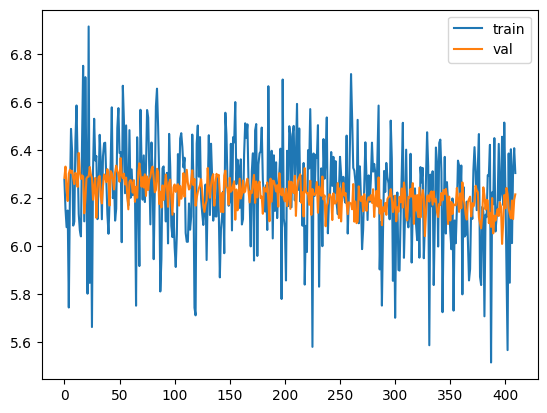

In [10]:
import matplotlib.pyplot as plt 

plt.plot(range(len(train_history)), train_history, label='train')
plt.plot(range(len(val_history)), val_history, label='val')
plt.legend()

In [ ]:
import os
import shutil

dir = './ckpts/test_ckpt'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "ckpts/test_ckpt/model.pth")

json_params = json.dumps({
    "dim": model_args.dim, 
    "n_layers": model_args.n_layers, 
    "n_heads": model_args.n_heads, 
    "vocab_size": model_args.vocab_size, 
    "multiple_of": model_args.multiple_of, 
    "norm_eps": model_args.norm_eps, 
}, indent=4)

with open(dir + "/params.json", "w") as outfile:
    outfile.write(json_params)